# DataCastle[药物分子筛选](http://www.dcjingsai.com/common/cmpt/%E5%9F%BA%E4%BA%8E%E4%BA%BA%E5%B7%A5%E6%99%BA%E8%83%BD%E7%9A%84%E8%8D%AF%E7%89%A9%E5%88%86%E5%AD%90%E7%AD%9B%E9%80%89_%E7%AB%9E%E8%B5%9B%E4%BF%A1%E6%81%AF.html)竞赛

In [68]:
import sklearn
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 建立指标

In [4]:
df_protein_train = pd.read_csv('E:\\git\protein_molecule_affinity\\datas_molecule\\df_protein_train.csv')   

In [5]:
len(set(df_protein_train.Protein_ID))

1653

可以得出Protein_ID有1653个不同的值，蛋白质信息数据没有重复值

In [6]:
df_affinity_train = pd.read_csv('E:\\git\protein_molecule_affinity\\datas_molecule\\df_affinity_train.csv')   

In [7]:
df1 = df_affinity_train.groupby(by = 'Protein_ID',as_index = False).count()['Protein_ID'] 
len(set(df_affinity_train.Protein_ID))

1650

In [8]:
set(df_protein_train.Protein_ID).difference(set(df_affinity_train.Protein_ID))

{1170, 1689, 1690}

这里的df_affinity_train中的Protein_ID只有1650个不同的值，相比df_protein_train中的数据仅少了3个：Protein_ID为1170、1689、1690的蛋白质没有和任何小分子比较过。

In [9]:
df_molecule = pd.read_csv('E:\\git\protein_molecule_affinity\\datas_molecule\\df_molecule.csv')

In [10]:
set(df_affinity_train.Molecule_ID).issubset(set(df_molecule.Molecule_ID))

True

训练集中的所有小分子的信息都在小分子信息集中

```
list1 = [i for i in df_protein_train['Protein_ID'] if i not in df1 ]
print(len(list1)) # 这里得出来的值应该是 3，但结果为351，why？

list2 = [i for i in df1  if i not in df_protein_train['Protein_ID'] ]
print(len(list2)) # 这里得出来的应该是0，但结果是347，why？
```

In [11]:
df_molecule.cyp_3a4.notnull().sum()

88023

将df_molecule中的不存在空值的列找出来,

In [12]:
no_nan_columns = [i for i in df_molecule.columns if df_molecule[i].notnull().sum() == 111216]  
have_nan_columns = [i for i in df_molecule.columns if df_molecule[i].notnull().sum() < 111216]  

print(have_nan_columns,'\n',no_nan_columns)

['cyp_3a4', 'cyp_2d6', 'ames_toxicity', 'fathead_minnow_toxicity', 'tetrahymena_pyriformis_toxicity', 'honey_bee', 'logP', 'CLtotal', 'hia', 'biodegradation', 'Vdd', 'p_glycoprotein_inhibition', 'NOAEL', 'bbb'] 
 ['Molecule_ID', 'Fingerprint', 'cyp_2c9', 'cell_permeability', 'renal_organic_cation_transporter', 'solubility']


In [13]:
len(have_nan_columns + no_nan_columns) == len(df_molecule.columns)

True

返回值为True，说明已经将df_Molecule的所有列都划分到这两个list中了。

In [14]:
pd.set_option('display.max_columns', 25)
df_ki_train = df_affinity_train.merge(df_protein_train,how='left',on = 'Protein_ID').merge(df_molecule,how='left',on = 'Molecule_ID')   

In [15]:
len(df_ki_train.columns)

23

In [16]:
set(df_molecule.Fingerprint.str.split(',').str.len())

{167}

In [17]:
feat = []
for i in range(0,len(df_molecule)):
    feat.append(df_molecule['Fingerprint'][i].split(', '))

feat = pd.DataFrame(feat)
feat = feat.astype('int')

feat.columns = ["Fingerprint_{0}".format(i) for i in range(0,167)] # 每个指纹长度都为167
feat["Molecule_ID"] = df_molecule['Molecule_ID']

In [18]:
df_ki_train = df_ki_train.merge(feat,how = 'left',on = 'Molecule_ID')

In [19]:
len(set(df_ki_train.Sequence.str.len()))

744

sequence有744钟不同的长度

In [20]:
df_ki_train['sequence_length'] = df_ki_train.Sequence.str.strip().str.len()

计算不同氨基酸在sequence中含有的个数，符号和氨基酸之间的对应见[维基百科蛋白质一级结构](https://zh.wikipedia.org/wiki/%E8%9B%8B%E7%99%BD%E8%B3%AA%E4%B8%80%E7%B4%9A%E7%B5%90%E6%A7%8B)

In [21]:
protein_list = list('ARNDCEQGHILKMFPSTWYV')
sequence_list = ['sequence_{}'.format(i) for i in protein_list]

In [22]:
for i in protein_list:
    df_ki_train['sequence_{}'.format(i)] = df_ki_train.Sequence.str.count(i)

Ki值在5.0，10.0左右发生迅速变化，为什么？
1、蛋白质的性质、小分子有关
2、碰巧出现的：刚好在做试验的时候，随机选出来的物质中他们ki值落在5~10中的蛋白质、分子多而已

In [25]:
df_ki_train['finger_print_one_count'] = df_ki_train.loc[:,'Fingerprint'].str.count('1')  

In [26]:
df_ki_train['finger_print_zero_count'] = df_ki_train.loc[:,'Fingerprint'].str.count('0')  

In [27]:
len(set(df_ki_train['finger_print_one_count']))

102

情况|数量|说明
---|---|---
数据行数|165084|
finger_print的类别|76507| <165084,说明存在Molecule_ID不同但是分子指纹相同的情况
finger_print中有1的个数的种类|102|

In [28]:
df_ki_train['sequence_length'] = df_ki_train.Sequence.str.strip().str.len()

In [29]:
df_ki_train.to_csv('E:\\git\\protein_molecule_affinity\\datas_molecule\\df_ki_train.csv',
                    index = False,
                    encoding = 'utf-8',
                    header = True )

## 探索

In [23]:
df_ki_train.sort_values(by = 'Ki',axis = 0,ascending = True)

,Protein_ID,Molecule_ID,Ki,Sequence,Fingerprint,cyp_3a4,cyp_2c9,cyp_2d6,ames_toxicity,fathead_minnow_toxicity,tetrahymena_pyriformis_toxicity,honey_bee,...,sequence_H,sequence_I,sequence_L,sequence_K,sequence_M,sequence_F,sequence_P,sequence_S,sequence_T,sequence_W,sequence_Y,sequence_V
132412,465,89514,-4.000000,MANSASPEQNQNHCSAINNSIPLMQGNLPTLTLSGKIRVTVTFFLF...,"1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0...",NaN,0.965630,0.970058,0.749624,0.000889,6.629223,0.027144,...,8,19,49,19,13,28,15,27,20,9,10,17
131939,44,89098,-2.660000,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0...",0.575853,0.734902,0.697199,0.871658,0.008367,3.563728,0.255132,...,1,12,12,6,2,2,6,1,8,2,1,7
131932,44,89091,-2.570000,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0...",0.491749,0.774622,0.865860,NaN,NaN,4.233384,NaN,...,1,12,12,6,2,2,6,1,8,2,1,7
131916,44,89075,-2.480000,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0...",0.193715,0.749287,0.724891,0.962256,0.000822,6.908474,0.241066,...,1,12,12,6,2,2,6,1,8,2,1,7
131907,44,89066,-2.430000,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0...",0.309770,0.757409,NaN,0.887842,0.002399,5.354315,0.550109,...,1,12,12,6,2,2,6,1,8,2,1,7
131929,44,89088,-2.430000,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0...",NaN,0.763353,0.670675,0.962341,0.001884,5.827994,0.274086,...,1,12,12,6,2,2,6,1,8,2,1,7
131914,44,89073,-2.400000,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0...",NaN,0.736518,0.638538,0.981926,0.000880,6.934709,0.237508,...,1,12,12,6,2,2,6,1,8,2,1,7
131920,44,89079,-2.400000,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0...",0.183684,0.798228,0.823932,0.964015,0.000632,7.384370,0.441807,...,1,12,12,6,2,2,6,1,8,2,1,7
131925,44,89084,-2.400000,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0...",0.440346,0.667758,0.673940,0.866821,0.003546,4.841460,0.327220,...,1,12,12,6,2,2,6,1,8,2,1,7
131942,44,89101,-2.360000,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,"1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0...",0.459340,0.738996,NaN,0.923994,0.002536,5.414086,0.234457,...,1,12,12,6,2,2,6,1,8,2,1,7


### Ki整体分布情况

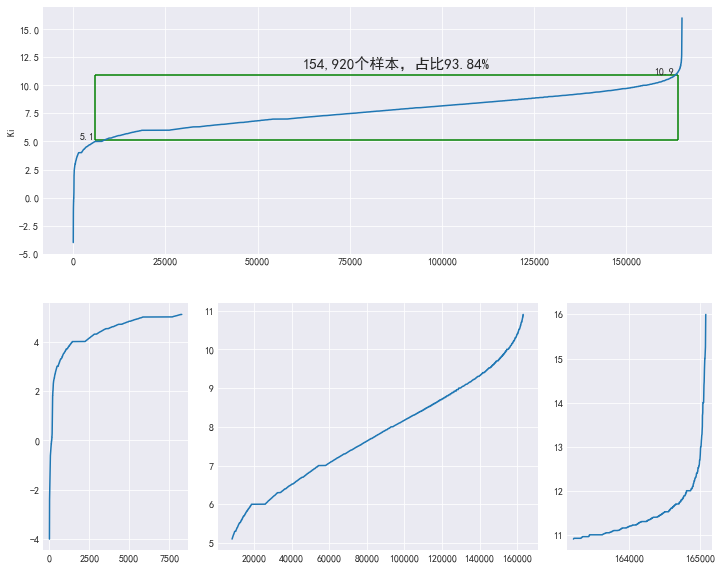

In [187]:
plt.figure(figsize = (12,10))
sns.set_style('darkgrid')
plt.rcParams['font.family'] = ['SimHei']

square_bottom = 5.1
square_top = 10.9
square_left = 6000
square_right = 164000

ax0 = plt.subplot2grid((2,4),(0,0),colspan = 4)
ax0.plot(list(range(df_ki_train_ki_length)),df_ki_train.sort_values(by = 'Ki',ascending = True).Ki)    

ax0.vlines(x = square_left,ymin = square_bottom,ymax = square_top,
           colors = 'green',linestyle='-')
ax0.hlines(y = square_bottom,xmin = square_left,xmax = square_right,
           colors = 'green',linestyle = '-')
ax0.hlines( y=square_top,xmin = square_left,xmax = square_right,
           colors = 'green',linestyle = '-')
ax0.vlines(x = square_right,ymin = square_bottom,ymax = square_top,
           colors = 'green',linestyle = '-')  

ax0.text(5900,square_bottom,'{}'.format(square_bottom), 
         horizontalalignment='right',verticalalignment='bottom')
ax0.text(163000,square_top,'{}'.format(square_top), 
         horizontalalignment='right',verticalalignment='bottom')

num1 = df_ki_train.loc[(df_ki_train.Ki <= square_top) & (df_ki_train.Ki >= square_bottom),'Ki'].count()
num2 = num1 / df_ki_train.Ki.count() 
ax0.text(87500,11.2,'{0:,d}个样本，占比{1:.2%}'.format(num1,num2),
        horizontalalignment='center',verticalalignment='bottom',
        fontsize = 15 )
ax0.set_ylabel('Ki')

ax1 = plt.subplot2grid((2,4),(1,0))
df1 = df_ki_train.loc[df_ki_train.Ki < square_bottom,:].sort_values(by = 'Ki',ascending = True)
ax1.plot(list(range(len(df1))),df1.Ki)


ax2 = plt.subplot2grid((2,4),(1,1),colspan = 2)
df2 = df_ki_train.loc[(df_ki_train.Ki <= square_top) & (df_ki_train.Ki >= square_bottom),:].sort_values(by = 'Ki',ascending = True) 
ax2.plot(list(range(len(df1),len(df1)+len(df2))),df2.Ki)

ax3 = plt.subplot2grid((2,4),(1,3))
df3 = df_ki_train.loc[df_ki_train.Ki > square_top,:].sort_values(by = 'Ki',ascending = True)
ax3.plot( list(range(len(df2)+len(df1),df_ki_train_ki_length )), df3.Ki )

想到了指数级增长：在任何一点往前看，都是平的，往后看都是垂直的。

In [92]:
df_ki_train['rank_ki'] = np.nan
df_ki_train.loc[df_ki_train.Ki < square_bottom,'rank_ki'] = 1
df_ki_train.loc[(df_ki_train.Ki >= square_bottom) & (df_ki_train.Ki <= square_top),'rank_ki'] = 2   
df_ki_train.loc[df_ki_train.Ki > square_top,'rank_ki'] = 3

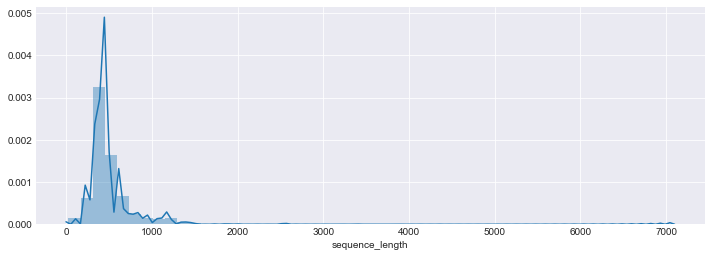

In [139]:
plt.figure(figsize = (12,4))
sns.distplot(a = df_ki_train.sequence_length,
             kde = True ，)

从上图可以得出，大多数蛋白质含有的氨基酸的个数<=1300个，极少量的蛋白质含有的氨基超过1300

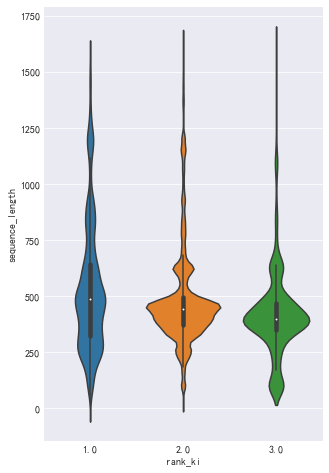

In [168]:
plt.figure(figsize = (5,8))
plt.rcParams['font.family'] = ['SimHei']

sns.violinplot(x = 'rank_ki',y = 'sequence_length',
            data = df_ki_train.loc[df_ki_train.sequence_length <=1700])

蛋白质中氨基酸的个数与ki值关系不明显

### 三种cyp酶与ki值之间的关系

In [114]:
len(df_ki_train[['cyp_2c9','cyp_3a4']])

165084

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize = (9,5))
sns.distplot(a = df_ki_train.groupby(by = 'sequence_length',as_index = False).count().sequence_length   
           ,kde = True)

In [142]:
df_ki_train[['cyp_2c9','cyp_2d6']].dropna().cyp_2c9.corr(df_ki_train[['cyp_2c9','cyp_2d6']].dropna().cyp_2d6)

-0.12220062512753185

cyp_2c9和cyp_2d6呈现出一定的负相关，相关性很弱。

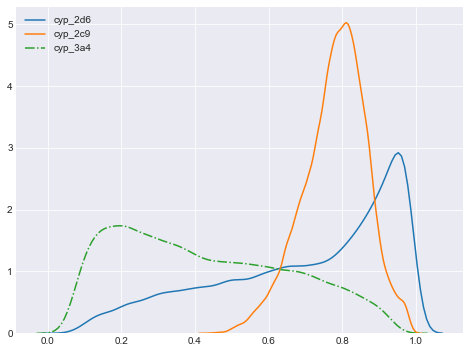

In [164]:
sns.set_style('darkgrid')
f,ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))  
cyp_2c9 = df_ki_train[['cyp_2c9','cyp_2d6','cyp_3a4']].dropna()['cyp_2d6']
cyp_2c6 = df_ki_train[['cyp_2c9','cyp_2d6','cyp_3a4']].dropna()['cyp_2c9']
cyp_3a4 = df_ki_train[['cyp_2c9','cyp_2d6','cyp_3a4']].dropna()['cyp_3a4']

sns.kdeplot(cyp_2c9,ax = ax1)
sns.kdeplot(cyp_2c6,ax = ax1)
sns.kdeplot(cyp_3a4,ax = ax1,linestyle = '-.')

ax1.legend(loc='upper left')

3种cyp酶的频率分布有明显差异，但是他们和ki值的关系是？先尝试一下线性回归

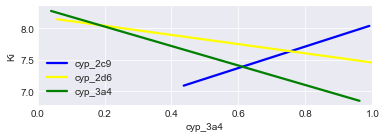

In [242]:
sns.set_style('darkgrid')
ax1 = plt.subplot2grid((2,1),(1,0))
# subplot2grid(shape,loc,) 返回loc位置的ax
# 还有其它2种方法：subplot(nrows, ncols, index, **kwargs) 返回index位置的ax  
# subplots(nrows,ncols,**kwargs) 返回figure，所有的ax

sns.regplot(x = 'cyp_2c9',y='Ki',
            data = df_ki_train[['cyp_2c9','cyp_2d6','cyp_3a4','Ki']].dropna(),
            scatter = False,
            order = 1, # 如果比1大的话，就用np.polyfit，最小二乘法进行拟合
            ci=None, # 不现实置信区间
            truncate=True,color = 'blue',
            ax = ax1)

sns.regplot( x = 'cyp_2d6',y='Ki',
            data = df_ki_train[['cyp_2c9','cyp_2d6','cyp_3a4','Ki']].dropna(),
            scatter = False,color = 'yellow',order = 1,
            ci=None, truncate=True,ax = ax1)

sns.regplot(x = 'cyp_3a4',y='Ki',
           data = df_ki_train[['cyp_2c9','cyp_2d6','cyp_3a4','Ki']].dropna(),
           scatter = False,color = 'green',order = 1,
           ci=None, truncate=True,ax = ax1)

ax1.legend(['cyp_2c9','cyp_2d6','cyp_3a4'],loc = 'lower left')

有差异，但是不明显

### 毒性测试与Ki值之间的关系

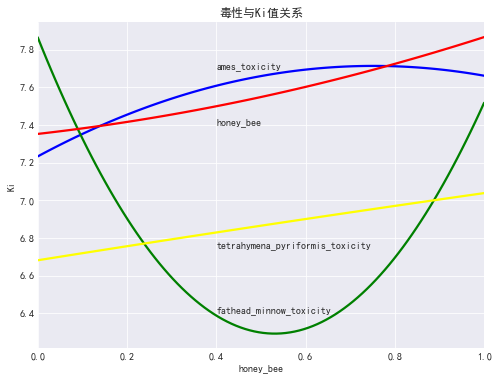

In [213]:
sns.set_style('darkgrid')
plt.rcParams['font.family'] = ['SimHei']
f,ax1 = plt.subplots(1,1,figsize = (8,6))

toxicity_list = ['ames_toxicity', 'fathead_minnow_toxicity', 
                 'tetrahymena_pyriformis_toxicity', 'honey_bee']
color_list = ['blue','green','yellow','red']
for toxicity ,color in zip(toxicity_list,color_list):
    sns.regplot(x = toxicity,y = 'Ki',
           data = df_ki_train[['ames_toxicity', 'fathead_minnow_toxicity', 
                               'tetrahymena_pyriformis_toxicity', 
                               'honey_bee','Ki']].dropna(),
           ci = None,ax = ax1,color = color,order = 2,
               scatter = False)

plt.title('毒性与Ki值关系')
loc_list = [[0.4,7.7],[0.4,6.4],[0.4,6.75],[0.4,7.4]]
for loc,toxicity in zip(loc_list,toxicity_list):
    plt.text(loc[0],loc[1],s = toxicity)

所以采用普通线性回归模型时，最好选择最小二乘法采用曲线进行拟合，sklearn中哪个方法是曲线拟合？怎么处理空值？

In [216]:
features = ['cyp_2c9', 'cell_permeability', 'renal_organic_cation_transporter', 
            'solubility','sequence_length'] + list(feat.columns) +  sequence_list
x = df_ki_train[features]
y_true = df_ki_train['Ki']
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.isotonic import IsotonicRegression
ir = IsotonicRegression()
ir_score = cross_val_score(x,y_true,cv = 5,scoring = 'neg_mean_squared_erro').mean()
ir_score

In [31]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr_score = cross_val_score(lr,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean()  
lr_score

-2.2479637569985895

In [46]:
# from sklearn import neighbors
# knn = neighbors.KNeighborsRegressor(5,weights = 'distance')
# score_knn = cross_val_score(knn,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean()

-19.062013610319788

In [42]:
knn_score = -19.06201361

score_knn = -19.06201361<br>
算一遍大概用了5分钟

In [49]:
from sklearn import tree
dtr = tree.DecisionTreeRegressor()
dtr_score = cross_val_score(dtr,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean()  
dtr_score

-16.177484133812747

dtr_score = -16.358652077676734
大概用了1分钟，但是一直没有运行结束

In [32]:
from sklearn import ensemble
rfr = ensemble.RandomForestRegressor(10)
rfr_score = cross_val_score(rfr,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean()  
rfr_score

-14.365528859046643

rfr_score = -14.365528859046643
用了5分钟

In [ ]:
# from sklearn import svm
# svr = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
# cross_val_score(svr,x,y_true,cv=2,scoring = 'neg_mean_squared_error').mean()
# 这个算了5分钟还没算出来，放弃了

In [33]:
from sklearn import linear_model
sgdr = linear_model.stochastic_gradient.SGDRegressor()
sgdr_score = cross_val_score(sgdr,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean()  

E:\miniconda\envs\course_py35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [34]:
sgdr_score

-4.5685744436339307e+35

In [35]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha = 0.1)
lasso_score = cross_val_score(lasso,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean() 
lasso_score

-2.34899458418018

lasso_score = -2.34899458418018
大概算了2分钟

In [36]:
ridge = linear_model.Ridge(alpha = 0.5)
ridge_score = cross_val_score(ridge,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean() 
ridge_score

-2.2473856634289935

In [37]:
from sklearn import linear_model
br = linear_model.BayesianRidge()
br_score = cross_val_score(br,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean()  
br_score

-2.2402293766020835

In [55]:
# from sklearn.ensemble import AdaBoostRegressor
# abr = AdaBoostRegressor()
# abr_score = cross_val_score(abr,x,y_true,cv=5,scoring='neg_mean_squared_error').mean()  
# abr_score
abr_score = np.nan
# 算了5分钟+，放弃用它了

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr_score = cross_val_score(gbr,x,y_true,cv=5,scoring='neg_mean_squared_error').mean()  
gbr_score

-9.2704837963037328

In [45]:
# from sklearn.ensemble import BaggingRegressor
# bgr = BaggingRegressor()
# bgr_score = cross_val_score(bgr,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean()  
# 算了5分钟+，放弃用这个了
bgr_score = -15.202450905551052

-15.202450905551052

In [56]:
# from sklearn.tree import ExtraTreeRegressor
# etr = ExtraTreeRegressor()
# etr_score = cross_val_score(etr,x,y_true,cv=5,scoring = 'neg_mean_squared_error').mean()  
etr_score = -3.9789111357868365
# 用时5+，放弃了

In [57]:
models = [['LinearRegression',lr_score,'instantly'],
          ['KNeighborsRegressor',knn_score,'5 min +'],
          ['DecisionTreeRegressor',dtr_score,'1 min +'],
          ['RandomForestRegressor',rfr_score,'5 min +'],
          ['SGDRegressor',sgdr_score,'instantly'],
          ['Lasso',lasso_score,'2 min +'],
          ['Ridge',ridge_score,'instantly'],
          ['BayesianRidge',br_score,'instantly'],
          ['AdaBoostRegressor',abr_score,'inf'],
         [ 'GradientBoostingRegressor',gbr_score,'instantly'],
          ['BaggingRegressor',bgr_score,'instantly'],
         [ 'ExtraTreeRegressor',etr_score,'5 min +']]

In [63]:
df_score = pd.DataFrame(models)
df_score.columns = ['model','score','time']
df_score.sort_values(by='score',ascending = False) 

,model,score,time
7,BayesianRidge,-2.240229e+00,instantly
6,Ridge,-2.247386e+00,instantly
0,LinearRegression,-2.247964e+00,instantly
5,Lasso,-2.348995e+00,2 min +
11,ExtraTreeRegressor,-3.978911e+00,5 min +
9,GradientBoostingRegressor,-9.270484e+00,instantly
3,RandomForestRegressor,-1.436553e+01,5 min +
10,BaggingRegressor,-1.520245e+01,instantly
2,DecisionTreeRegressor,-1.617748e+01,1 min +
1,KNeighborsRegressor,-1.906201e+01,5 min +


In [92]:
len(set(df_affinity_test.Protein_ID))

413

只有413种不同的Protein_ID

In [110]:
set(df_affinity_test.Protein_ID).isdisjoint(set(df_protein_train.Protein_ID))

True

a.isdisjoint(b)  True if a and b have no elements in common <br>
需要预测(test)的蛋白质都不在训练集中，所以预测时要从氨基酸这个level去预测，训练模型时也要从这个level出发

In [111]:
set(df_affinity_test.Molecule_ID).issubset(set(df_molecule.Molecule_ID))

True

a.issubset(b) N/A True if the elements of a are all contained in b <br>
需要预测(test)的小分子信息都在小分子数据集(df_molecule)中

In [66]:
df_affinity_test = pd.read_csv('E:\\git\\protein_molecule_affinity\\datas_molecule\\df_affinity_test_toBePredicted.csv')     

df_protein_test = pd.read_csv('E:\\git\\protein_molecule_affinity\\datas_molecule\\df_protein_test.csv')    

df_ki_test = df_affinity_test.merge(df_protein_test,how = 'left',on = 'Protein_ID').merge(df_molecule,how = 'left',on = 'Molecule_ID')   

df_ki_test = df_ki_test.merge(feat,how = 'left',on = 'Molecule_ID')

df_ki_test['sequence_length'] = df_ki_test.Sequence.str.len()

In [67]:
for i in protein_list:
    df_ki_test['sequence_{}'.format(i)] = df_ki_train.Sequence.str.count(i)

In [64]:
model = br.fit(x,y_true)

In [68]:
x_test = df_ki_test[features]
y_pred = model.predict(x_test)
df_ki_test['Ki'] = y_pred
df_ki_test[['Protein_ID','Molecule_ID','Ki']].to_csv('E:\\git\\protein_molecule_affinity\\datas_molecule\\df_affinity_test.csv',
                                                     index = False,
                                                    encoding = 'utf-8',
                                                    header = True)   